<a href="https://colab.research.google.com/github/sorennelson/MediaRecommendation/blob/master/Collaborative_Filtering_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pickle
import copy

import random

# Model

In [0]:
class CollaborativeFilteringModel(object):
    """ A representation for a CF Model. Use to pass data easier."""
    def __init__(self, media_type):
        if media_type == 'books':
          self.media_num = 9992
          self.users_num = 13124
        else:
          self.media_num = 9123
          self.users_num = 467
  
        self.ratings = np.zeros((self.media_num, self.users_num))
        self.rated = np.zeros((self.media_num, self.users_num))
        self.ratings_mean = np.array((1, self.media_num))
        self.mapping = {}
        
        self.__import_ratings(media_type)
        
        self.train_ratings = self.ratings.copy()
        self.train_rated = self.rated.copy()

        self.features_num = 0
        self.item_params = np.zeros((1, 1))
        self.user_params = np.zeros((1, 1))

        self.val_indices = []
        self.val_ratings = []

        self.rated_indices = np.nonzero(self.rated)
        self.rated_indices = list(zip(self.rated_indices[0], self.rated_indices[1]))
        np.random.shuffle(self.rated_indices)

    def __import_ratings(self, media_type):
        if media_type == 'books': path = './book_ratings.csv'
        else: path = './movie_ratings.csv'
        with open(path, 'r') as f:
            uid = 0
            csv_uid = 1
            media = 0

            for line in f:
                terms = line.strip().split(',')

                # Increase user
                if terms[0] != csv_uid and terms[1] != str(3618):
                  csv_uid = terms[0]
                  uid += 1

                  if terms[1] in self.mapping:
                    mid = self.mapping[terms[1]]
                  else:
                    mid = media
                    self.mapping[terms[1]] = mid
                    media += 1

                  self.ratings[mid, uid] = float(terms[2])
                  self.rated[mid, uid] = 1

                # No increase in user
                elif terms[1] != str(3618):

                  if terms[1] in self.mapping:
                    mid = self.mapping[terms[1]]
                  else:
                    mid = media
                    self.mapping[terms[1]] = mid
                    media += 1

                  self.ratings[mid, uid] = float(terms[2])
                  self.rated[mid, uid] = 1
          
        self.ratings_mean = np.mean(self.ratings, axis=1)
        self.ratings = self.ratings - self.ratings_mean.reshape(-1, 1)
        self.ratings /= 5

    def set_user_item_params(self, features_num):
        """Sets the media and user parameters randomly for a given number of features."""
        self.features_num = features_num
        self.item_params = np.random.rand(self.media_num, features_num)
        self.user_params = np.random.rand(self.users_num, features_num)

    def separate_validation_set(self, iteration):
        self.reset_ratings()
        
        start = int(0.1 * len(self.rated_indices) * iteration)
        end = int(0.1 * len(self.rated_indices) * (iteration+1))

        self.val_indices = []
        self.val_ratings = []

        for i in range(start, end):
            x, y = self.rated_indices[i]

            self.val_indices.append(self.rated_indices[i])
            self.val_ratings.append(self.ratings[x, y])

            self.train_ratings[x, y] = 0
            self.train_rated[x, y] = 0

        self.val_indices = np.array(self.val_indices)
        self.val_ratings = np.array(self.val_ratings)
        
    def reset_ratings(self):
        self.train_ratings = self.ratings.copy()
        self.train_rated = self.rated.copy()
        
    def add_user(self):
        self.users_num += 1

        new_rated = np.zeros((self.media_num, self.users_num))
        new_rated[:, :-1] = self.rated
        self.rated = new_rated

        new_ratings = np.zeros((self.media_num, self.users_num))
        new_ratings[:, :-1] = self.ratings
        self.ratings = new_ratings

        self._denormalize_ratings()
        print(self.ratings[:, -1].shape)
        self.ratings[:, -1] -= self.ratings_mean # Demean new user
        self._normalize_ratings()

        new_user_params = np.random.random((self.users_num, self.user_params.shape[1]))
        new_user_params[:-1, :] = self.user_params
        self.user_params = new_user_params

    def _demean(self):
        self.ratings -= self.ratings_mean.reshape(-1, 1)

    def _remean(self):
        self.ratings += self.ratings_mean.reshape(-1, 1)

    def _normalize_ratings(self):
        self.ratings /= 5

    def _denormalize_ratings(self):
        self.ratings *= 5

# Algorithm

## Collaborative Filtering

In [0]:
def run_collaborative_filtering(media_type, iters):
    model = CollaborativeFilteringModel(media_type)
    best = [0, 0, 0, 1.0]

    if media_type == "books":
        reg_params = [120]
        learning_rates = [0.0002]
        param_count = [6]
    else:
        reg_params = [100]
        learning_rates = [0.001]
        param_count = [8]

    for features_num in param_count:
        i = 0
        for reg_param in reg_params:
            for learning_rate in learning_rates:
                best = _run_hyperparameters(model, iters, features_num, learning_rate, i, best, True, reg_param)
                i += 1
    print("BEST MODEL:", best[0], best[1], best[2], best[3])

    model.set_user_item_params(best[0])
    model.reset_ratings()
    _, _ = _run_gradient_descent(iters, model, best[2], best[1], False)

    rmse = _compute_rmse(model)
    print("RMSE:", rmse)
    
    return model
    

def _run_hyperparameters(model, num_epochs, features_num, learning_rate, iteration, best, val, reg_param=0):
    print(features_num, ', R:', reg_param, ', LR:', learning_rate, ', Epochs:', num_epochs)

    model.set_user_item_params(features_num)
    model.separate_validation_set(iteration)

    losses, val_losses = _run_gradient_descent(num_epochs, model, learning_rate, reg_param, val)
    _create_loss_graph(losses, val_losses)

    rmse = _compute_rmse(model)
    print("RMSE:", rmse)

    val_rmse = _compute_val_rmse(model)
    print("VAL RMSE:", val_rmse)

    return [model.features_num, reg_param, learning_rate, val_rmse] if val_rmse < best[3] else best

In [0]:
def overfit_collaborative_filtering(media_type):
  """Use to find where model starts to overfit"""
    model = CollaborativeFilteringModel(media_type)
    best = [0, 0, 0, 1.0]
    param_count = [12, 20]

    if media_type == "books":
        learning_rates = [0.0003]
    else:
        learning_rates = [0.001]

    i = 0
    for features_num in param_count:
        for learning_rate in learning_rates:
            best = _run_hyperparameters(model, 150, features_num, learning_rate, i, best, True)
            i += 1
    
    print("BEST MODEL:", best[0], best[1], best[2], best[3])
    model.set_user_item_params(features_num)
    model.reset_ratings()
    _, _ = _run_gradient_descent(300, model, best[2], best[1], False)

    rmse = _compute_rmse(model)
    print("RMSE:", rmse)

## Gradient Descent

In [0]:
def _run_gradient_descent(num_iters, model, learning_rate, reg_param, val):
    train_losses = []
    val_losses = []

    for i in range(num_iters):
        error = _compute_error(model)
        item_gradient = _compute_item_gradient(error, model, reg_param)
        user_gradient = _compute_user_gradient(error, model, reg_param)

        loss = _compute_loss(error, model, reg_param)
        train_losses.append(loss)

        if val:
          val_loss = _compute_val_loss(model)
          val_losses.append(val_loss)

        model.item_params -= learning_rate * item_gradient
        model.user_params -= learning_rate * user_gradient

    return train_losses, val_losses


def _compute_error(model):
    error = np.dot(model.item_params, model.user_params.T) - model.train_ratings
    return model.train_rated * error  # only for rated media


def _compute_item_gradient(error, model, reg_param):
    gradient = np.dot(error, model.user_params)
    regularization = reg_param * model.item_params if reg_param != 0 else 0
    return gradient + regularization


def _compute_user_gradient(error, model, reg_param):
    gradient = np.dot(error.T, model.item_params)
    regularization = reg_param * model.user_params if reg_param != 0 else 0
    return gradient + regularization

## Loss

In [0]:
def _compute_loss(error, model, reg_param):
    loss = np.sum(np.square(error)) / 2
    item_regularization = (reg_param / 2) * np.sum(np.square(model.item_params)) if reg_param != 0 else 0
    user_regularization = (reg_param / 2) * np.sum(np.square(model.user_params)) if reg_param != 0 else 0

    return loss + item_regularization + user_regularization


def _compute_val_loss(model):
    all_predictions = np.dot(model.item_params, model.user_params.T)
    predictions = []

    for i in range(len(model.val_indices)):
        x, y = model.val_indices[i]
        predictions.append(all_predictions[x, y])

    predictions = np.array(predictions)
    error = predictions - model.val_ratings
    loss = np.sum(np.square(error)) / 2
    return loss

In [0]:
def _create_loss_graph(train_losses, val_losses):    
    train_losses = train_losses[10:]
    train_losses = [train_losses[i] for i in range(len(train_losses)) if i % 5 == 0]
    train_losses /= np.max(train_losses)
    
    val_losses = val_losses[10:]
    val_losses = [val_losses[i] for i in range(len(val_losses)) if i % 5 == 0]
    val_losses /= np.max(train_losses)
    
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'bo', label='Train Loss')
    plt.plot(epochs, val_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

## RMSE

In [0]:
def _compute_rmse(model):
    predictions = np.dot(model.item_params, model.user_params.T) * 5
    predictions += model.ratings_mean.reshape(-1, 1)
    
    predictions *= model.train_rated
    
    return np.sqrt(mean_squared_error(model.train_ratings, predictions)) / 5


def _compute_val_rmse(model):
    all_predictions = np.dot(model.item_params, model.user_params.T) * 5
    all_predictions += model.ratings_mean.reshape(-1, 1)

    predictions = []

    for i in range(len(model.val_indices)):
        x, y = model.val_indices[i]
        predictions.append(all_predictions[x, y])

    predictions = np.array(predictions)

    return np.sqrt(mean_squared_error(model.val_ratings, predictions)) / 5

## Predictions

In [0]:
def _create_movie_predictions(model):
    predictions = np.dot(model.item_params, model.user_params.T) * 5
    predictions += model.ratings_mean.reshape(-1, 1)

    non_rated = (model.rated - 1) * (- 1)
    predictions *= non_rated 
    return predictions

# Training

## Movies

### Training

In [0]:
overfit_collaborative_filtering('movies')

8 , R: 45 , LR: 0.001 , Epochs: 200


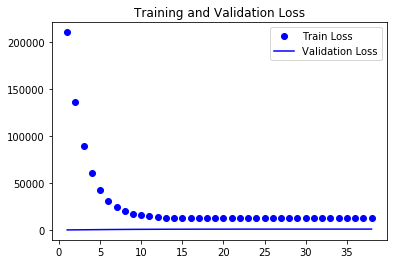

RMSE: 0.019113326707430718
VAL RMSE: 0.15669604031445922
8 , R: 100 , LR: 0.001 , Epochs: 200


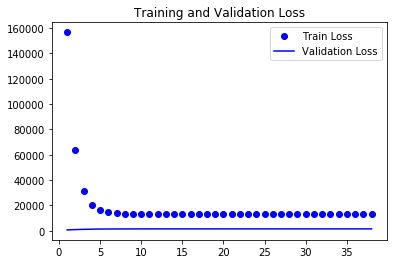

RMSE: 0.014167683553428451
VAL RMSE: 0.11041956253775669
8 , R: 200 , LR: 0.001 , Epochs: 200


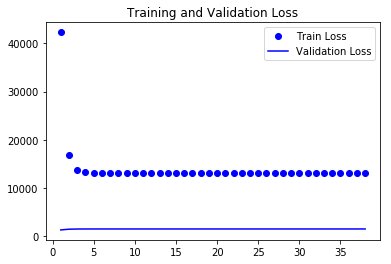

RMSE: 0.014157317163783423
VAL RMSE: 0.11128070182327618
BEST MODEL: 8 100 0.001 0.11041956253775669
RMSE: 0.014814734781133288


In [0]:
run_collaborative_filtering('movies', 200)

8 , R: 30 , LR: 0.001 , Epochs: 300


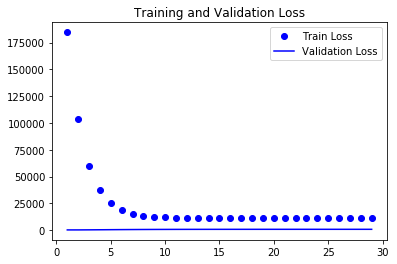

RMSE: 0.02948229738151928
VAL RMSE: 0.2369015044968938
8 , R: 45 , LR: 0.001 , Epochs: 300


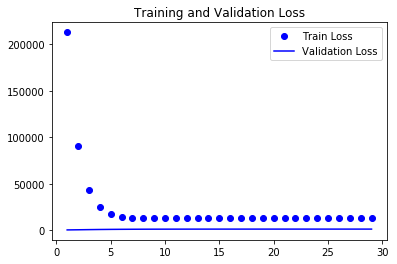

RMSE: 0.019015030098572732
VAL RMSE: 0.15637998788644905
8 , R: 100 , LR: 0.001 , Epochs: 300


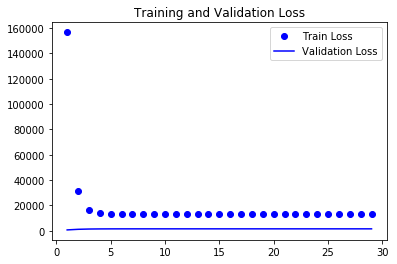

RMSE: 0.014143669591033307
VAL RMSE: 0.11240333116609595
BEST MODEL: 8 100 0.001 0.11240333116609595
RMSE: 0.01481474177070699


In [0]:
run_collaborative_filtering('movies', 300)

### Pickling

8 , R: 100 , LR: 0.001 , Epochs: 300


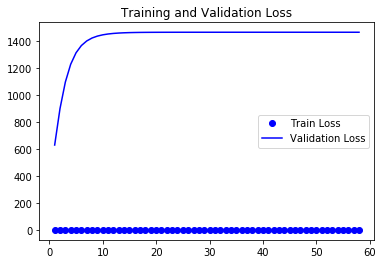

RMSE: 0.014128186335625653
VAL RMSE: 0.11367092009036539
BEST MODEL: 8 100 0.001 0.11367092009036539
RMSE: 0.014814741770305211


In [0]:
model = run_collaborative_filtering('movies', 300)

pickled_model = pickle.dumps(model)
model_from_pickle = pickle.loads(pickled_model)

In [0]:
print(model_from_pickle.ratings[100, 1])
print(model_from_pickle.rated[100, 1])

predictions = _create_movie_predictions(model_from_pickle)
print(predictions[100, 1])

-0.024839400428265525
0.0
0.12419700223434843


In [0]:
model = copy.deepcopy(model_from_pickle)

In [0]:
test_model = copy.deepcopy(model)

i = 0
while i < 1000:
  m = int(random.random() * 9123)
  u = int(random.random() * 467)
  
  if model.rated[m, u] == 0: 
    i += 1
    # DeNormalize and ReMean
    model.ratings *= 5
    model.ratings += model.ratings_mean.reshape(-1, 1)
    
    # Set new rating
    model.ratings[m, u] = 5
    model.rated[m, u] = 1
  
    # Normalize and Demean
    model.ratings_mean = np.mean(model.ratings, axis=1)
    model.ratings -= model.ratings_mean.reshape(-1, 1)
    model.ratings /= 5
    model.reset_ratings()
    
    # Compute RMSE for original model
    rmse = _compute_rmse(model)
    print("O RMSE:", rmse)
    
    # Run test model once every update
    test_model.ratings = model.ratings.copy()
    test_model.rated = model.rated.copy()
    test_model.reset_ratings()
        
    _, _ = _run_gradient_descent(2, test_model, 0.001, 100, False)
    test_rmse = _compute_rmse(test_model)
    print("N RMSE:", test_rmse)
    
    print('-- Difference --', rmse - test_rmse)
    
# Run test model once every 100 updates 
test_model_2 = copy.deepcopy(model)
_, _ = _run_gradient_descent(20, test_model_2, 0.001, 100, False)

# Compute RMSE for newest model
rmse = _compute_rmse(test_model_2)
print("NEWEST RMSE:", rmse)  

In [0]:
model.ratings *= 5
model.ratings += model.ratings_mean.reshape(-1, 1)

In [0]:
print(model.ratings[100, 1])
print(model.rated[101, 1])
print(model.rated[105, 1])

0.0
0.0
0.0


In [0]:
model.ratings_mean = np.mean(model.ratings, axis=1)
model.ratings -= model.ratings_mean.reshape(-1, 1)
model.ratings /= 5

In [0]:
model.reset_ratings()

In [0]:
print(model.ratings[100, 1])

0.9730192719486082


In [0]:
rmse = _compute_rmse(model)
print("RMSE:", rmse)

RMSE: 0.07866597650029451


In [0]:
test_model_1 = copy.deepcopy(model)
_, _ = _run_gradient_descent(5, test_model_1, 0.001, 100, False)

rmse = _compute_rmse(test_model_1)
print("RMSE:", rmse)

RMSE: 0.07866597669436351


In [0]:
test_model_2 = copy.deepcopy(model)
_, _ = _run_gradient_descent(50, test_model_2, 0.001, 100, False)

rmse = _compute_rmse(test_model_2)
print("RMSE:", rmse)

RMSE: 0.18361059685752854


In [0]:
test_model_3 = copy.deepcopy(model)
_, _ = _run_gradient_descent(100, test_model_3, 0.001, 100, False)

rmse = _compute_rmse(test_model_3)
print("RMSE:", rmse)

RMSE: 0.2258721475391031


In [0]:
test_model_4 = copy.deepcopy(model)
_, _ = _run_gradient_descent(2, test_model_4, 0.001, 100, False)

rmse = _compute_rmse(test_model_4)
print("RMSE:", rmse)

RMSE: 0.07866597653438596


### Add User

8 , R: 100 , LR: 0.001 , Epochs: 300


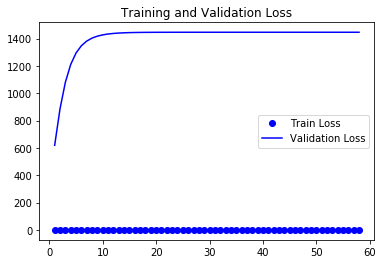

RMSE: 0.014151332906919353
VAL RMSE: 0.11178300895461664
BEST MODEL: 8 100 0.001 0.11178300895461664
RMSE: 0.01481474177015935


In [0]:
model = run_collaborative_filtering('movies', 300)

In [0]:
model.add_user()
model.reset_ratings()

(9123,)


In [0]:
model.

## Books

### Tuning Hyperparameters

10 , R: 2 , LR: 0.0001 , Epochs: 300


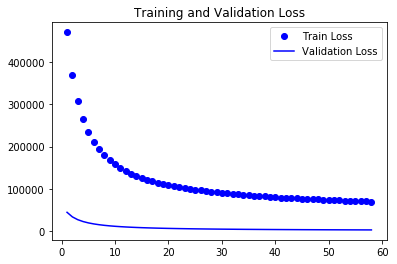

RMSE: 0.05539112888888842
VAL RMSE: 0.6634196637755834
10 , R: 10 , LR: 0.0001 , Epochs: 300


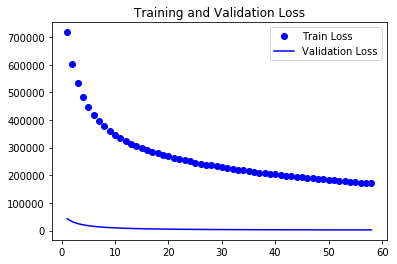

RMSE: 0.050595365292189345
VAL RMSE: 0.5989957542120125
12 , R: 2 , LR: 0.0001 , Epochs: 300


KeyboardInterrupt: ignored

In [0]:
run_collaborative_filtering('books', 300)

8 , R: 10 , LR: 0.0002 , Epochs: 200


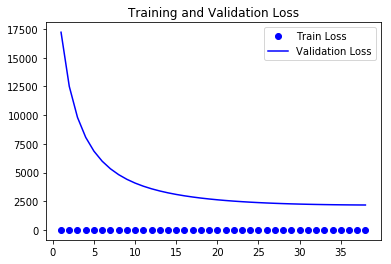

RMSE: 0.04902184280577412
VAL RMSE: 0.5781478379000861
8 , R: 20 , LR: 0.0002 , Epochs: 200


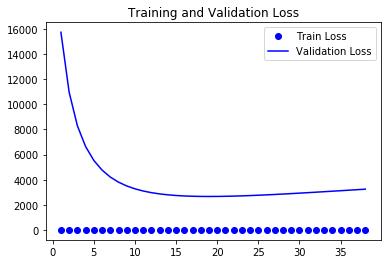

RMSE: 0.043691360371005336
VAL RMSE: 0.512095110329627
16 , R: 10 , LR: 0.0002 , Epochs: 200


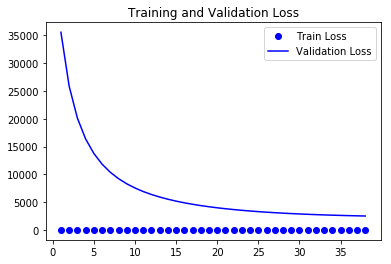

RMSE: 0.049356246874529115
VAL RMSE: 0.5862826854416028
16 , R: 20 , LR: 0.0002 , Epochs: 200


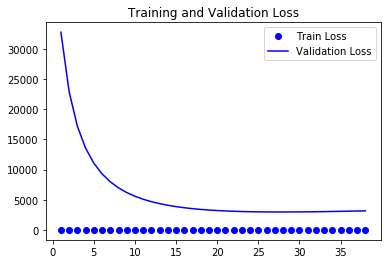

RMSE: 0.04376581268504872
VAL RMSE: 0.5140733667948736
BEST MODEL: 8 20 0.0002 0.512095110329627
RMSE: 0.04669673398577358


In [0]:
model = run_collaborative_filtering('books', 200)

8 , R: 20 , LR: 0.0002 , Epochs: 300


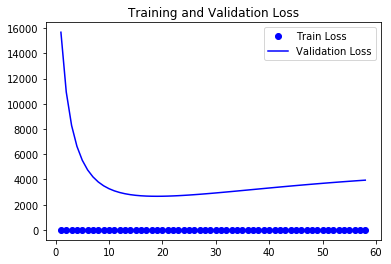

RMSE: 0.04247096562063448
VAL RMSE: 0.4976151102996485
8 , R: 30 , LR: 0.0002 , Epochs: 300


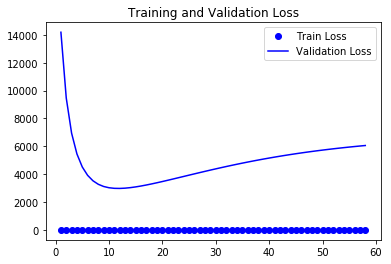

RMSE: 0.03804351537542369
VAL RMSE: 0.4463968159591441
10 , R: 20 , LR: 0.0002 , Epochs: 300


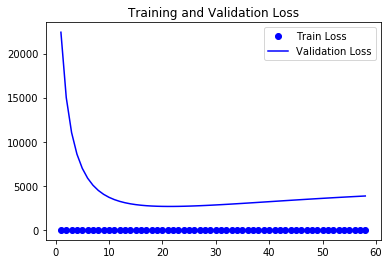

RMSE: 0.042608266337269746
VAL RMSE: 0.4992831649699562
10 , R: 30 , LR: 0.0002 , Epochs: 300


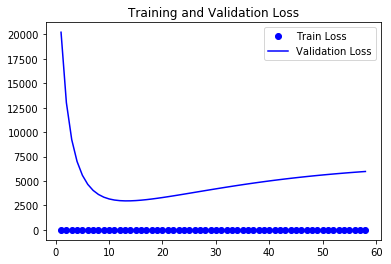

RMSE: 0.03811979438022957
VAL RMSE: 0.4472531288594971
BEST MODEL: 8 30 0.0002 0.4463968159591441
RMSE: 0.041188293453716676


In [0]:
run_collaborative_filtering('books', 300)

6 , R: 30 , LR: 0.0002 , Epochs: 300


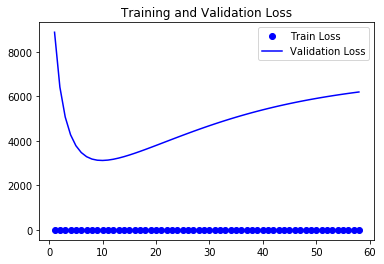

RMSE: 0.03794595426487584
VAL RMSE: 0.44524779212377413
6 , R: 50 , LR: 0.0002 , Epochs: 300


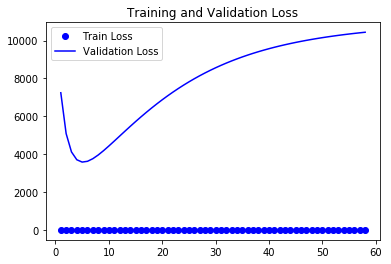

RMSE: 0.03114071252279387
VAL RMSE: 0.36453683953115357
6 , R: 100 , LR: 0.0002 , Epochs: 300


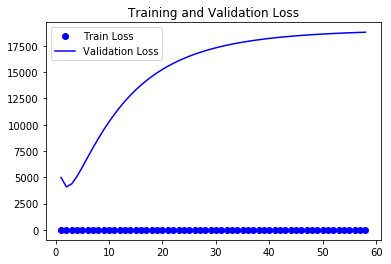

RMSE: 0.019760908586429517
VAL RMSE: 0.22847321129268697
8 , R: 30 , LR: 0.0002 , Epochs: 300


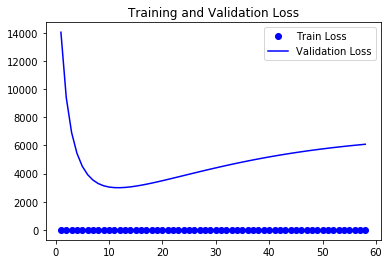

RMSE: 0.03803763288393951
VAL RMSE: 0.4462859763220462
8 , R: 50 , LR: 0.0002 , Epochs: 300


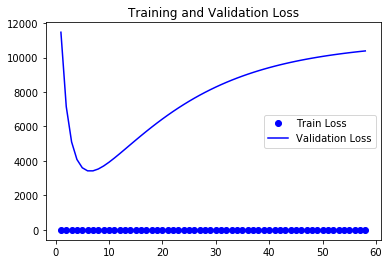

RMSE: 0.03117620070285687
VAL RMSE: 0.3649611408397402
8 , R: 100 , LR: 0.0002 , Epochs: 300


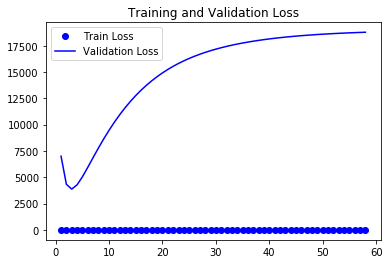

RMSE: 0.01977077372799352
VAL RMSE: 0.2285923510176881
BEST MODEL: 6 100 0.0002 0.22847321129268697
RMSE: 0.022683227340218437


In [0]:
run_collaborative_filtering('books', 300)

### Final Model

6 , R: 120 , LR: 0.0002 , Epochs: 300


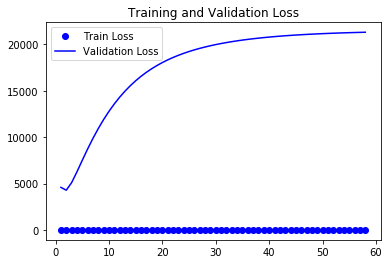

RMSE: 0.016582964760274405
VAL RMSE: 0.1905707814931114
BEST MODEL: 6 120 0.0002 0.1905707814931114
RMSE: 0.019318432645467103


In [0]:
run_collaborative_filtering('books', 300)